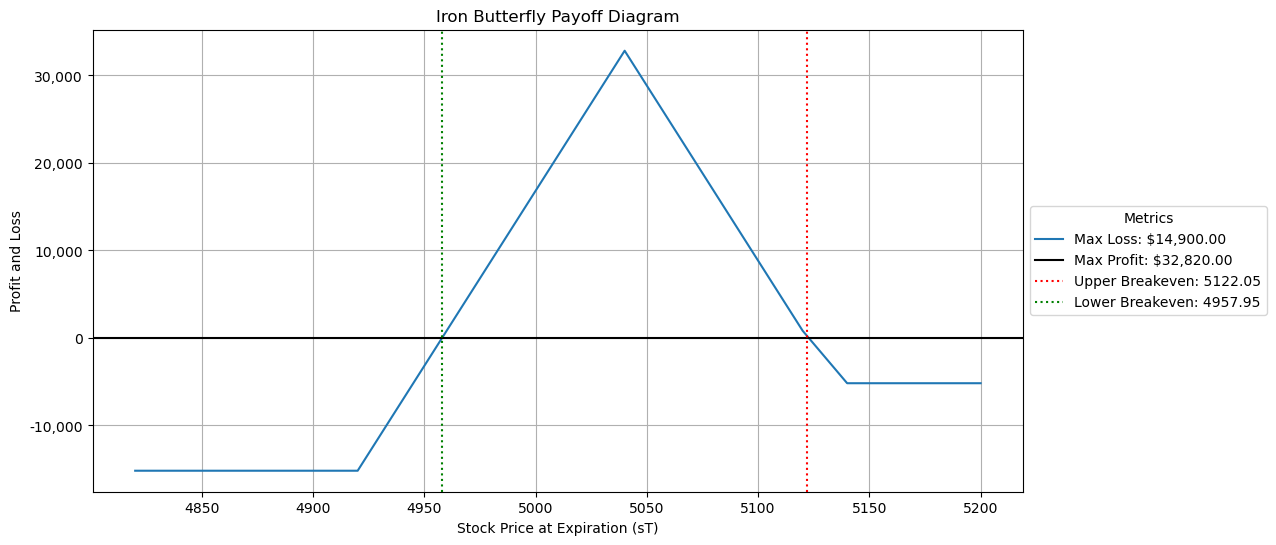

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.ticker as ticker


def call_payoff(sT, strike, premium):
    return np.maximum(sT - strike, 0) - premium

def put_payoff(sT, strike, premium):
    return np.maximum(strike - sT, 0) - premium

class Option:
    def __init__(self, type, strike, premium):
        self.type = type
        self.strike = strike
        self.premium = premium

    def payoff(self, sT):
        if self.type == 'call':
            return call_payoff(sT, self.strike, self.premium)
        elif self.type == 'put':
            return put_payoff(sT, self.strike, self.premium)
        else:
            raise ValueError(f'Invalid option type: {self.type}')

    def __str__(self):
        return f'{self.type.capitalize()} option with strike {self.strike} and premium {self.premium}'

class OptionSpread:
    def __init__(self, long_option, short_option):
        self.long_option = long_option
        self.short_option = short_option

    def payoff(self, sT):
        return self.long_option.payoff(sT) - self.short_option.payoff(sT)

    def __str__(self):
        return f'{self.long_option} - {self.short_option}'

class BearCallSpread(OptionSpread):
    def __init__(self, long_call, short_call):
        super().__init__(long_call, short_call)
        self.long_call = long_call
        self.short_call = short_call

    def max_loss(self):
        return (long_call.strike - short_call.strike + self.short_call.premium - self.long_call.premium)
   
    def max_profit(self):
        return (self.short_call.premium - self.long_call.premium)

    def __str__(self):
        return f'Bear Call Spread: {self.long_option} - {self.short_option}'
    
class BullPutSpread(OptionSpread):
    def __init__(self, short_put, long_put):
        super().__init__(long_put, short_put)
        self.long_put = long_put
        self.short_put = short_put
    
    def max_loss(self):
        return (short_put.strike - short_put.strike + self.short_put.premium - self.long_put.premium) 
   
    def max_profit(self):
        return (self.short_put.premium - self.long_put.premium)

    def __str__(self):
        return f'Bull Put Spread: {self.long_option} - {self.short_option}'

class IronCondor:
    def __init__(self, bear_call_spread, bull_put_spread):
        self.bear_call_spread = bear_call_spread
        self.bull_put_spread = bull_put_spread

    def payoff(self, sT):
        return self.bear_call_spread.payoff(sT) + self.bull_put_spread.payoff(sT)
    
    def max_loss(self):
        return min(self.bear_call_spread.max_loss(), self.bull_put_spread.max_loss())

    def max_profit(self):
        return self.bear_call_spread.max_profit() + self.bull_put_spread.max_profit()
    
    def upper_breakeven(self):
        return self.bear_call_spread.short_call.strike + self.max_profit()
    
    def lower_breakeven(self):
        return self.bull_put_spread.short_put.strike - self.max_profit()
    
    def __str__(self):
        return f'Iron Condor'

class IronButterfly(IronCondor):
    def __init__(self, bear_call_spread, bull_call_spread):
        if bear_call_spread.short_call.strike != bull_call_spread.short_put.strike:
            raise ValueError('Invalid Iron Butterfly: Short put and long call must have same strikes')
        super().__init__(bear_call_spread, bull_call_spread)

    def __str__(self):
     return f'Iron Butterfly'


def black_scholes_price(spot, strike, time_to_expiry, implied_vol, risk_free_rate, option_type):
    d1 = (np.log(spot / strike) + (risk_free_rate + 0.5 * implied_vol ** 2) * time_to_expiry) / (implied_vol * np.sqrt(time_to_expiry))
    d2 = d1 - implied_vol * np.sqrt(time_to_expiry)

    if option_type == 'call':
        price = spot * norm.cdf(d1) - strike * np.exp(-risk_free_rate * time_to_expiry) * norm.cdf(d2)
    elif option_type == 'put':
        price = strike * np.exp(-risk_free_rate * time_to_expiry) * norm.cdf(-d2) - spot * norm.cdf(-d1)
    else:
        raise ValueError('Invalid option type')

    return price

def t0_line(spot, strike, time_to_expiry, implied_vol, risk_free_rate, option_type, initial_cost):
    current_price = black_scholes_price(spot, strike, time_to_expiry, implied_vol, risk_free_rate, option_type)
    return current_price - initial_cost

# Define parameters (adjust as needed)
sT = np.linspace(4820, 5200, 20)
strike_long_call = 5135
premium_long_call = 39.51
strike_short_call = 5040
premium_short_call = 84.31
strike_short_put = 5040
premium_short_put = 70.56
strike_long_put = 4920
premium_long_put = 33.31
shares_per_contract = 100
quantity = 4

# Create options
long_call = Option('call', strike_long_call, premium_long_call)
short_call = Option('call', strike_short_call, premium_short_call)
short_put = Option('put', strike_short_put, premium_short_put)
long_put = Option('put', strike_long_put, premium_long_put)

# Create spreads
bear_call_spread = BearCallSpread(long_call, short_call)
bull_put_spread = BullPutSpread(short_put, long_put)

# Create iron butterfly
iron_butterfly = IronButterfly(bear_call_spread, bull_put_spread)

# Plot Payoff Diagram
payoff_diagram = iron_butterfly.payoff(sT) * shares_per_contract * quantity
max_loss = iron_butterfly.max_loss() * shares_per_contract * quantity
max_profit = iron_butterfly.max_profit() * shares_per_contract * quantity
upper_breakeven = iron_butterfly.upper_breakeven()
lower_breakeven = iron_butterfly.lower_breakeven()

plt.plot(sT, payoff_diagram, label=iron_butterfly)
plt.axhline(y=0, color='black', linestyle='-', label='Net Profit/Loss')
plt.axvline(x=upper_breakeven, color='red', linestyle=':', label=f'Upper Breakeven: {upper_breakeven}')
plt.axvline(x=lower_breakeven, color='green', linestyle=':', label=f'Lower Breakeven: {lower_breakeven}')

# Format y-axis labels with commas
formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Stock Price at Expiration (sT)')
plt.ylabel('Profit and Loss')
plt.title('Iron Butterfly Payoff Diagram')
plt.legend(title='Metrics', labels=[
    f'Max Loss: {f"${max_loss:,.2f}"}',
    f'Max Profit: {f"${max_profit:,.2f}"}',
    f'Upper Breakeven: {upper_breakeven}',
    f'Lower Breakeven: {lower_breakeven}'
], loc='center left',bbox_to_anchor=(1, 0.5))

# Set size of plot
fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.grid(True)
plt.show()